## Reference

+ [Dive into Deep Learning, Chapter 11.11](https://zh.d2l.ai/chapter_optimization/lr-scheduler.html)

+ [d2l package, PyTorch version](https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py)

+ [PyTorch docs](https://pytorch.org/docs/stable/index.html)

+ [PaddlePaddle docs](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/index_cn.html)


Especially for this homework:

+ [Source code for `paddle.optimizer`](https://github.com/PaddlePaddle/Paddle/blob/release/2.2/python/paddle/optimizer/optimizer.py)

+ [Source code for `torch.optim.sgd`](https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD)



In [1]:
!nvidia-smi

Wed Apr 27 15:45:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Toy Problem

We begin with a toy problem that is cheap enough to compute easily, yet sufficiently nontrivial to illustrate some of the key aspects. For that we pick a slightly modernized version of LeNet (relu instead of sigmoid activation, MaxPooling rather than AveragePooling), as applied to Fashion-MNIST. Moreover, we hybridize the network for performance. 

In [2]:
%matplotlib inline

import math

from d2l import paddle as d2l

import paddle
from paddle import nn
from paddle.nn import functional as F
from paddle.optimizer.lr import LRScheduler


In [3]:
def net_fn():
    model = nn.Sequential(
        nn.Conv2D(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2D(kernel_size=2, stride=2),
        nn.Conv2D(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2D(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

In [4]:
loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [5]:
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            # trainer.zero_grad()
            trainer.clear_grad()
            # X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with paddle.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == paddle.optimizer.lr.__name__:
                # Using In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                # for param_group in trainer._param_groups:
                #     param_group = scheduler(epoch)
                trainer.set_lr(scheduler(epoch))

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

Let us have a look at what happens if we invoke this algorithm with default settings, such as a learning rate of $0.3$ and train for $30$ iterations. Note how the training accuracy keeps on increasing while progress in terms of test accuracy stalls beyond a point. The gap between both curves indicates overfitting.

train loss 0.177, train acc 0.931, test acc 0.890


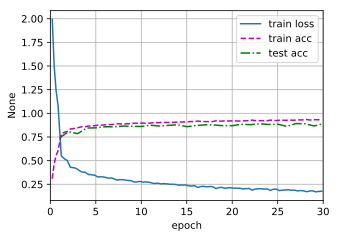

In [6]:
lr, num_epochs = 0.3, 30
net = net_fn()
# trainer = torch.optim.SGD(net.parameters(), lr=lr)
trainer = paddle.optimizer.SGD(parameters=net.parameters(), learning_rate=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## Schedulers

One way of adjusting the learning rate is to set it explicitly at each step. This is conveniently achieved by the set_learning_rate method. We could adjust it downward after every epoch (or even after every minibatch), e.g., in a dynamic manner in response to how optimization is progressing.

In [8]:
lr = 0.1
# trainer.param_groups[0]["lr"] = lr
# trainer._param_groups[0] = lr
trainer.set_lr(lr)
print(f'learning rate is now {trainer.get_lr():.2f}')

learning rate is now 0.10


More generally we want to define a scheduler. When invoked with the number of updates it returns the appropriate value of the learning rate. Let us define a simple one that sets the learning rate to $\eta = \eta_0 \left( t+1 \right)^{-\frac{1}{2} }$.

In [9]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

Let us plot its behavior over a range of values.

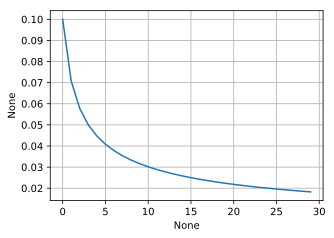

In [10]:
num_epochs = 30
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(paddle.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Now let us see how this plays out for training on Fashion-MNIST. We simply provide the scheduler as an additional argument to the training algorithm.

train loss 0.228, train acc 0.916, test acc 0.891


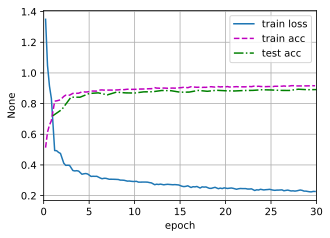

In [11]:
net = net_fn()
trainer = paddle.optimizer.SGD(parameters=net.parameters(), learning_rate=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

## Policies

### Factor Scheduler

One alternative to a polynomial decay would be a multiplicative one, that is $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ for $\alpha \in (0, 1)$. To prevent the learning rate from decaying beyond a reasonable lower bound the update equation is often modified to $\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$.


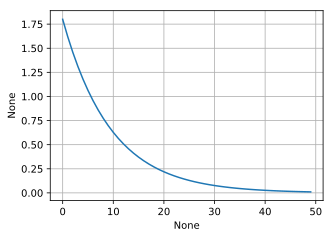

In [12]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(paddle.arange(50), [scheduler(t) for t in range(50)])

### Multi Factor Scheduler

A common strategy for training deep networks is to keep the learning rate piecewise constant and to decrease it by a given amount every so often. That is, given a set of times when to decrease the rate, such as $s = \{5, 10, 20\}$ decrease $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ whenever $t \in s$. Assuming that the values are halved at each step we can implement this as follows.

VERY DIFFERNT from the way of combining sgd and multistepLR in PyTorch.

+ Corresponding implementation of ``torch.optim.lr_scheduler.MultiStepLR`` 
in paddle should be ``paddle.optimizer.lr.MultiStepDecay``.

+ ``paddle.optimizer.lr.LRScheduler`` is a base class, and the common
interface of a learning rate scheduler is defined in it.

+ ``paddle.optimizer.lr.MultiStepDecay`` inherit the base class ``paddle.optimizer.lr.LRScheduler``.

    ```py
    class MultiStepDecay(LRScheduler):
    ```

+ In PyTorch, `lr_scheduler` is a module in `torch.optim`, the base class offered for inheriting is named `_LRScheduler`.

    ```py
    class MultiStepLR(_LRScheduler):
    """Decays the learning rate of each parameter group by gamma once the
    number of epoch reaches one of the milestones. Notice that such decay can
    happen simultaneously with other changes to the learning rate from outside
    this scheduler. When last_epoch=-1, sets initial lr as lr."""

    ```

Reference: 
+ [Doc for `paddle.optimizer.lr.MultiStepDecay`](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/optimizer/lr/MultiStepDecay_cn.html#multistepdecay)

+ [Source code for `paddle.optimizer.lr.MultiStepDecay`](https://github.com/PaddlePaddle/Paddle/blob/release/2.2/python/paddle/optimizer/lr.py#L888)

+ [Source code for `torch.optim.lr_scheduler`](https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html)


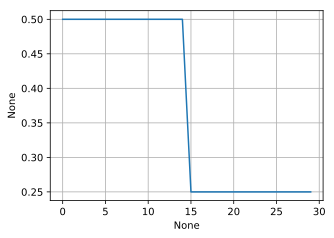

In [13]:
net = net_fn()

scheduler = paddle.optimizer.lr.MultiStepDecay(learning_rate=0.5, milestones=[15, 30], gamma=0.5)
trainer = paddle.optimizer.SGD(parameters=net.parameters(), learning_rate=scheduler)

def get_lr(trainer, scheduler):
    # lr = scheduler.get_last_lr()[0]
    # lr = scheduler()
    lr = trainer.state_dict()['LR_Scheduler']['last_lr']
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(paddle.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

train loss 0.151, train acc 0.943, test acc 0.888


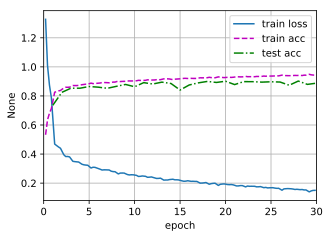

In [14]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### Cosine Scheduler

A rather perplexing heuristic was proposed by `Loshchilov.Hutter.2016`. It relies on the observation that we might not want to decrease the learning rate too drastically in the beginning and moreover, that we might want to "refine" the solution in the end using a very small learning rate. This results in a cosine-like schedule with the following functional form for learning rates in the range $t \in [0, T]$.

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$


Here $\eta_0$ is the initial learning rate, $\eta_T$ is the target rate at time $T$. Furthermore, for $t > T$ we simply pin the value to $\eta_T$ without increasing it again. In the following example, we set the max update step $T = 20$.


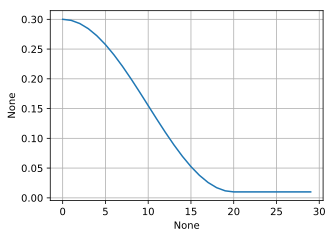

In [15]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(paddle.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

In the context of computer vision this schedule *can* lead to improved results. Note, though, that such improvements are not guaranteed (as can be seen below).


train loss 0.141, train acc 0.949, test acc 0.904


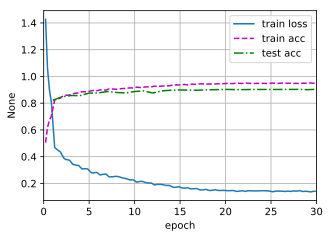

In [16]:
net = net_fn()
trainer = paddle.optimizer.SGD(parameters=net.parameters(), learning_rate=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### Warmup

In some cases initializing the parameters is not sufficient to guarantee a good solution. This particularly a problem for some advanced network designs that may lead to unstable optimization problems. We could address this by choosing a sufficiently small learning rate to prevent divergence in the beginning. Unfortunately this means that progress is slow. Conversely, a large learning rate initially leads to divergence.

A rather simple fix for this dilemma is to use a warmup period during which the learning rate *increases* to its initial maximum and to cool down the rate until the end of the optimization process. For simplicity one typically uses a linear increase for this purpose. This leads to a schedule of the form indicated below.


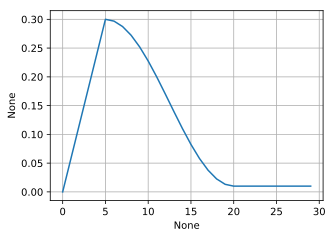

In [17]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(paddle.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Note that the network converges better initially (in particular observe the performance during the first 5 epochs).


train loss 0.141, train acc 0.950, test acc 0.908


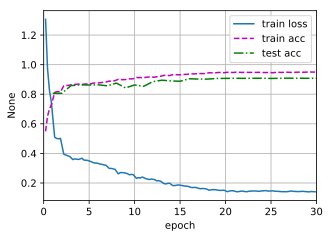

In [18]:
net = net_fn()
trainer = paddle.optimizer.SGD(parameters=net.parameters(), learning_rate=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

Warmup can be applied to any scheduler (not just cosine).



## Summary

+ Decreasing the learning rate during training can lead to improved accuracy and (most perplexingly) reduced overfitting of the model.

+ A piecewise decrease of the learning rate whenever progress has plateaued is effective in practice. Essentially this ensures that we converge efficiently to a suitable solution and only then reduce the inherent variance of the parameters by reducing the learning rate.

+ Cosine schedulers are popular for some computer vision problems. 

+ A warmup period before optimization can prevent divergence.

+ Optimization serves multiple purposes in deep learning. Besides minimizing the training objective, different choices of optimization algorithms and learning rate scheduling can lead to rather different amounts of generalization and overfitting on the test set (for the same amount of training error).